# Building your first Agent!
We are going to be building a simple agent. It looks like this:

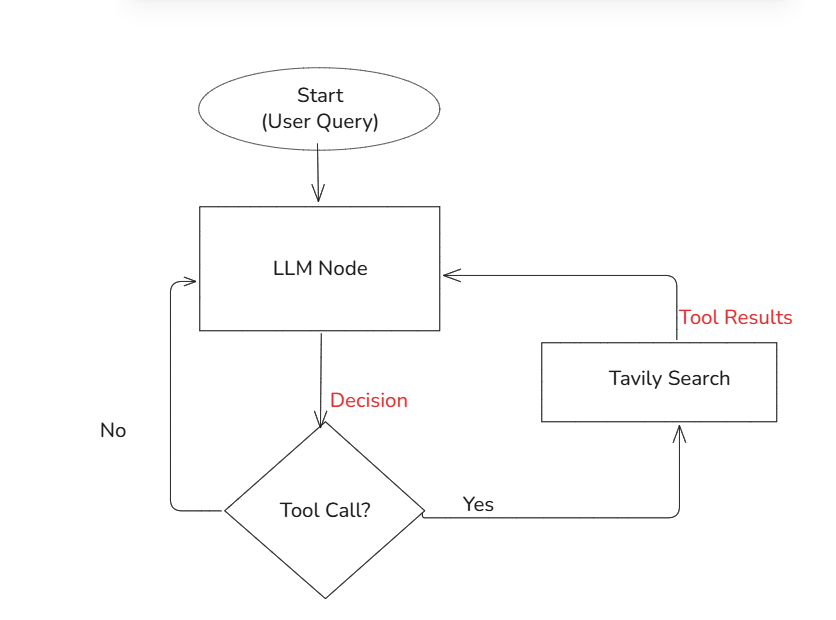

What we aim to demonstrate:
- The ability of an agent to make a decision.
- The ability of an LLM to integrate with external tools.
- In our case, we are using the Tavily tool.

## Install the necessary libraries.

In [7]:
#!pip install langchain langgraph
#!pip install langchain-groq
#!pip install langchain-tavily

In [4]:
#check if the installation was successful.
import langchain
langchain.__version__

'0.3.27'

## State
LangGraph workflows have nodes and edges literally depicting a graph! They also have a shared state- the state is visible to all of the nodes and can be commonly updated. Important thing to note is that any changes made by a node to the state persist across all nodes.

Let us start with a very simple state-
It has two variables-


*   query- The input query from user
*   response- The LLM's response to input query



In [41]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list, add_messages]

## LLM
We are going to use an LLM through the GROQ API. Groq API allows you to use multiple different models from llama and qwen to even gpt oss models. You will have to create an API key which you can do here:
https://console.groq.com/keys
For the list of available models, you can look here:


In [5]:
from langchain_groq import ChatGroq
GROQ_API_KEY = 'your api key here'
llm = ChatGroq(model_name= 'llama-3.1-8b-instant', api_key= GROQ_API_KEY)
response = llm.invoke('Where is Vellore?')

In [6]:
response

AIMessage(content='Vellore is a city located in the Indian state of Tamil Nadu. It serves as the administrative headquarters of Vellore district. The city is situated on the banks of the Palar River and is known for its historical significance, particularly due to the Vellore Fort, a 16th-century fort complex that played a crucial role in Indian history.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 73, 'prompt_tokens': 41, 'total_tokens': 114, 'completion_time': 0.131799818, 'prompt_time': 0.003480926, 'queue_time': 0.255655668, 'total_time': 0.135280744}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_8804b970d6', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--4d4b6265-a00c-4642-b0b2-83331279eaad-0', usage_metadata={'input_tokens': 41, 'output_tokens': 73, 'total_tokens': 114})

## Tool
Tavily's Search API is a search engine built specifically for AI agents (LLMs), delivering real-time, accurate, and factual results at speed.

### What you will need
* Install the Tavily package
* Create a tavily api key.

In [14]:
from langchain_tavily import TavilySearch
import os

TAVILY_API_KEY = 'your_tavily_api_key_here'
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

In [18]:
tavily_tool = TavilySearch(
    max_results=5,
    topic="general"
)

#response= tavily_tool.invoke({"query":"What time is the India match?"})

In [19]:
tools = [tavily_tool]

In [16]:
response

{'query': 'What time is the India match?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://indianexpress.com/article/sports/cricket/india-a-vs-australia-a-2nd-unofficial-test-live-streaming-time-kl-rahul-shreyas-iyer-10264314/',
   'title': 'India A vs Australia A 2nd Unofficial Test Live Streaming',
   'content': '7 hours ago—The India A vs Australia A second unofficial Test match is scheduled to start at9:30 am IST on Tuesdaywith the toss at 9:00 am IST. How to',
   'score': 0.48674685,
   'raw_content': None},
  {'url': 'https://www.usatoday.com/story/sports/2025/09/20/india-vs-pakistan-asia-cup/86238480007/',
   'title': 'India vs. Pakistan Asia Cup: Start time, squads, how to watch',
   'content': '2 days ago—Pakistan and India will meet on Sunday, Sept. 21 at10:30 a.m. ETfor the 2025 Asia Cup Super Four match at Dubai International Stadium.',
   'score': 0.43295085,
   'raw_content': None},
  {'url': 'https://www.aljazeera.com/sports/20

In [43]:
#create the chatbot node
def chatbot_node(state:State):
  query = state["messages"]
  llm_tool= llm.bind_tools(tools)
  llm_response = llm_tool.invoke(query)
  return{"messages":llm_response}

## Build the Graph

Next, we build the graph. The flow is going to look like <br>
START-> LLM -> TOOL CALL -> LLM -> END (with tool call) <br>
START -> LLM -> END

In [44]:
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

#add nodes
graph_builder.add_node("agent",chatbot_node)
graph_builder.add_node("tools",ToolNode(tools))

#add edges
graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges("agent", tools_condition)
graph_builder.add_edge("tools", "agent")
graph_builder.add_edge("agent",END)

#compile the graph
graph = graph_builder.compile()




## Display the graph.

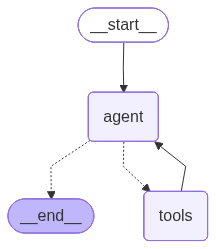

In [35]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [45]:
graph.invoke({"messages":"What is the weather in Chennai right now?"})


{'messages': [HumanMessage(content='What is the weather in Chennai right now?', additional_kwargs={}, response_metadata={}, id='9b6bf468-d82f-4183-b0b6-5defd409ea3d'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'jar2xas7b', 'function': {'arguments': '{"query":"Current weather in Chennai","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 1795, 'total_tokens': 1820, 'completion_time': 0.04225108, 'prompt_time': 0.109166456, 'queue_time': 0.227261523, 'total_time': 0.151417536}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c54ae48ece', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--112c059f-899e-486e-a7d8-f3c4aea0252d-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Current weather in Chennai', 'topic': 'news'}, 'id': 'jar2xas7b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1795, 'output_token

### Congrats! You have built your first agent :)
You can further explore how to add memory in your agent.